In [13]:
# Configure plots for inline use in Jupyter Notebook
%matplotlib inline

import datetime as dt

# Utilities
import boto3
import dateutil
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os

# Sentinel Hub
from sentinelhub import (
    CRS,
    BBox,
    ByocCollection,
    ByocCollectionAdditionalData,
    ByocCollectionBand,
    ByocTile,
    DataCollection,
    DownloadFailedException,
    MimeType,
    SentinelHubBYOC,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
)

config = SHConfig()
config.instance_id = os.environ.get("SH_INSTANCE_ID")
config.sh_client_id = os.environ.get("SH_CLIENT_ID")
config.sh_client_secret = os.environ.get("SH_CLIENT_SECRET")
config.aws_access_key_id = os.environ.get("username")
config.aws_secret_access_key = os.environ.get("password")    

In [14]:
# Initialize SentinelHubBYOC class
#https://sentinelhub-py.readthedocs.io/en/latest/reference/sentinelhub.html


byoc = SentinelHubBYOC(config=config)
print ("START--------------------------")
# list collections and tiles
# from: https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html
collections_iterator = byoc.iter_collections()
my_collections = list(collections_iterator)

for collection in my_collections:
    
    print("Collection name:", collection["name"])
    print("Collection id: ", collection["id"])
    tiles = list(byoc.iter_tiles(collection))
    for tile in tiles:
        print("Tile status: ", tile['status'])
        print("Tile created: ", tile['created'])
        print("Tile path: ", tile['path'])
        if(tile['status'] == "FAILED"):
            print("Ingestion failed error: ", tile['additionalData'])
    print("-------------------")
print ("end")

START--------------------------
Collection name: new collection
Collection id:  9ce57124-0cc8-4c4f-9812-327ca1942170
Tile status:  INGESTED
Tile created:  2023-02-17T10:46:31.166466Z
Tile path:  folder/(BAND).tif
-------------------
end


In [15]:
# get first tile of first collection
collections_iterator = byoc.iter_collections()
collection = next(collections_iterator)
tile = next(byoc.iter_tiles(collection))
tile

{'id': '4deec260-0fc0-401d-a763-300f08414e71',
 'created': '2023-02-17T10:46:31.166466Z',
 'ingestionStart': '2023-02-17T10:46:31.166466Z',
 'coverGeometry': {'type': 'Polygon',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:EPSG::3035'}},
  'coordinates': [[[4014669.999979591, 2933829.999639364],
    [4071359.999983392, 2933829.9996399865],
    [4071359.9999840036, 3015539.999661122],
    [4014669.999980342, 3015539.999660529],
    [4014669.999979591, 2933829.999639364]]]},
 'tileGeometry': {'type': 'Polygon',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:EPSG::3035'}},
  'coordinates': [[[4014670.0, 3015540.0],
    [4071360.0, 3015540.0],
    [4071360.0, 2933830.0],
    [4014670.0, 2933830.0],
    [4014670.0, 3015540.0]]]},
 'path': 'folder/(BAND).tif',
 'status': 'INGESTED',
 'additionalData': {'hasAddedPoints': True,
  'filesMetadata': {'UrbanAtlas2018_lux': {'headerSize': 1658,
    'etag': '"517fbe1f73c3ad2b51f2939e6fc58658-2"'}},
  'mi

In [16]:
### Lux extent box 6.20,49.60 : 6.34,49.66

x1 = 6.20  # degree
y1 = 49.60  # degree
x2 = 6.34  # degree
y2 = 49.66  # degree

bbox = x1, y1, x2, y2
aoi = BBox([x1, y1, x2, y2], crs=CRS.WGS84)
#spatial_res = 0.00018   # = 20.038 meters in degree

In [17]:
#https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html
#https://eurodatacube.com/notebooks/contributions/LPIS_LULC-Slo.ipynb
data_collection = DataCollection.define_byoc(collection["id"])
data_collection

<DataCollection.BYOC_9ce57124-0cc8-4c4f-9812-327ca1942170: DataCollectionDefinition(
  api_id: byoc-9ce57124-0cc8-4c4f-9812-327ca1942170
  catalog_id: byoc-9ce57124-0cc8-4c4f-9812-327ca1942170
  wfs_id: byoc-9ce57124-0cc8-4c4f-9812-327ca1942170
  collection_type: BYOC
  collection_id: 9ce57124-0cc8-4c4f-9812-327ca1942170
  is_timeless: False
  has_cloud_coverage: False
)>

In [22]:
##https://docs.sentinel-hub.com/api/latest/evalscript/

#SentinelHubBaseApiRequest.input_data(data_collection, identifier, time_interval, maxcc, mosaicking_order, upsampling, downsampling, other_args)
###################################################
## what is the band name of the tile? 
## from documentation:  
## "bands are not defined before the tile ingestion process. 
## BYOC service then automatically configures bands based on the first ingested tile 
## and names the band after the filename unless a band placeholder is defined"
## -> in this case, if tile was ingested with path="folder/(BAND).tif" then band name is equal to filename "UrbanAtlas2018_lux"

evalscript_test = """

//VERSION=3
function setup() {
  return {
    input: ["UrbanAtlas2018_lux"],
    output: { 
        bands: 1 ,
        sampleType: "UINT16" // raster format will be UINT16
        }
    
  };
}

function evaluatePixel(sample) {
  return [sample.UrbanAtlas2018_lux];
}
"""

request = SentinelHubRequest(
        evalscript=evalscript_test,
        input_data=[
            SentinelHubRequest.input_data(
                #data_collection=data_collection,
                data_collection=data_collection,
                #time_interval=tile_time
                # time_interval="2018"
                
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=aoi,
        size=bbox_to_dimensions(aoi, 10),
        config=config
    )
data = request.get_data()[0]

In [23]:
data

array([[31000, 31000, 31000, ..., 23000, 23000, 23000],
       [31000, 31000, 31000, ..., 23000, 23000, 12220],
       [31000, 31000, 31000, ..., 23000, 23000, 23000],
       ...,
       [12100, 12100, 12100, ..., 21000, 21000, 21000],
       [12100, 12100, 12100, ..., 31000, 31000, 31000],
       [12100, 12100, 12100, ..., 31000, 31000, 31000]], dtype=int32)

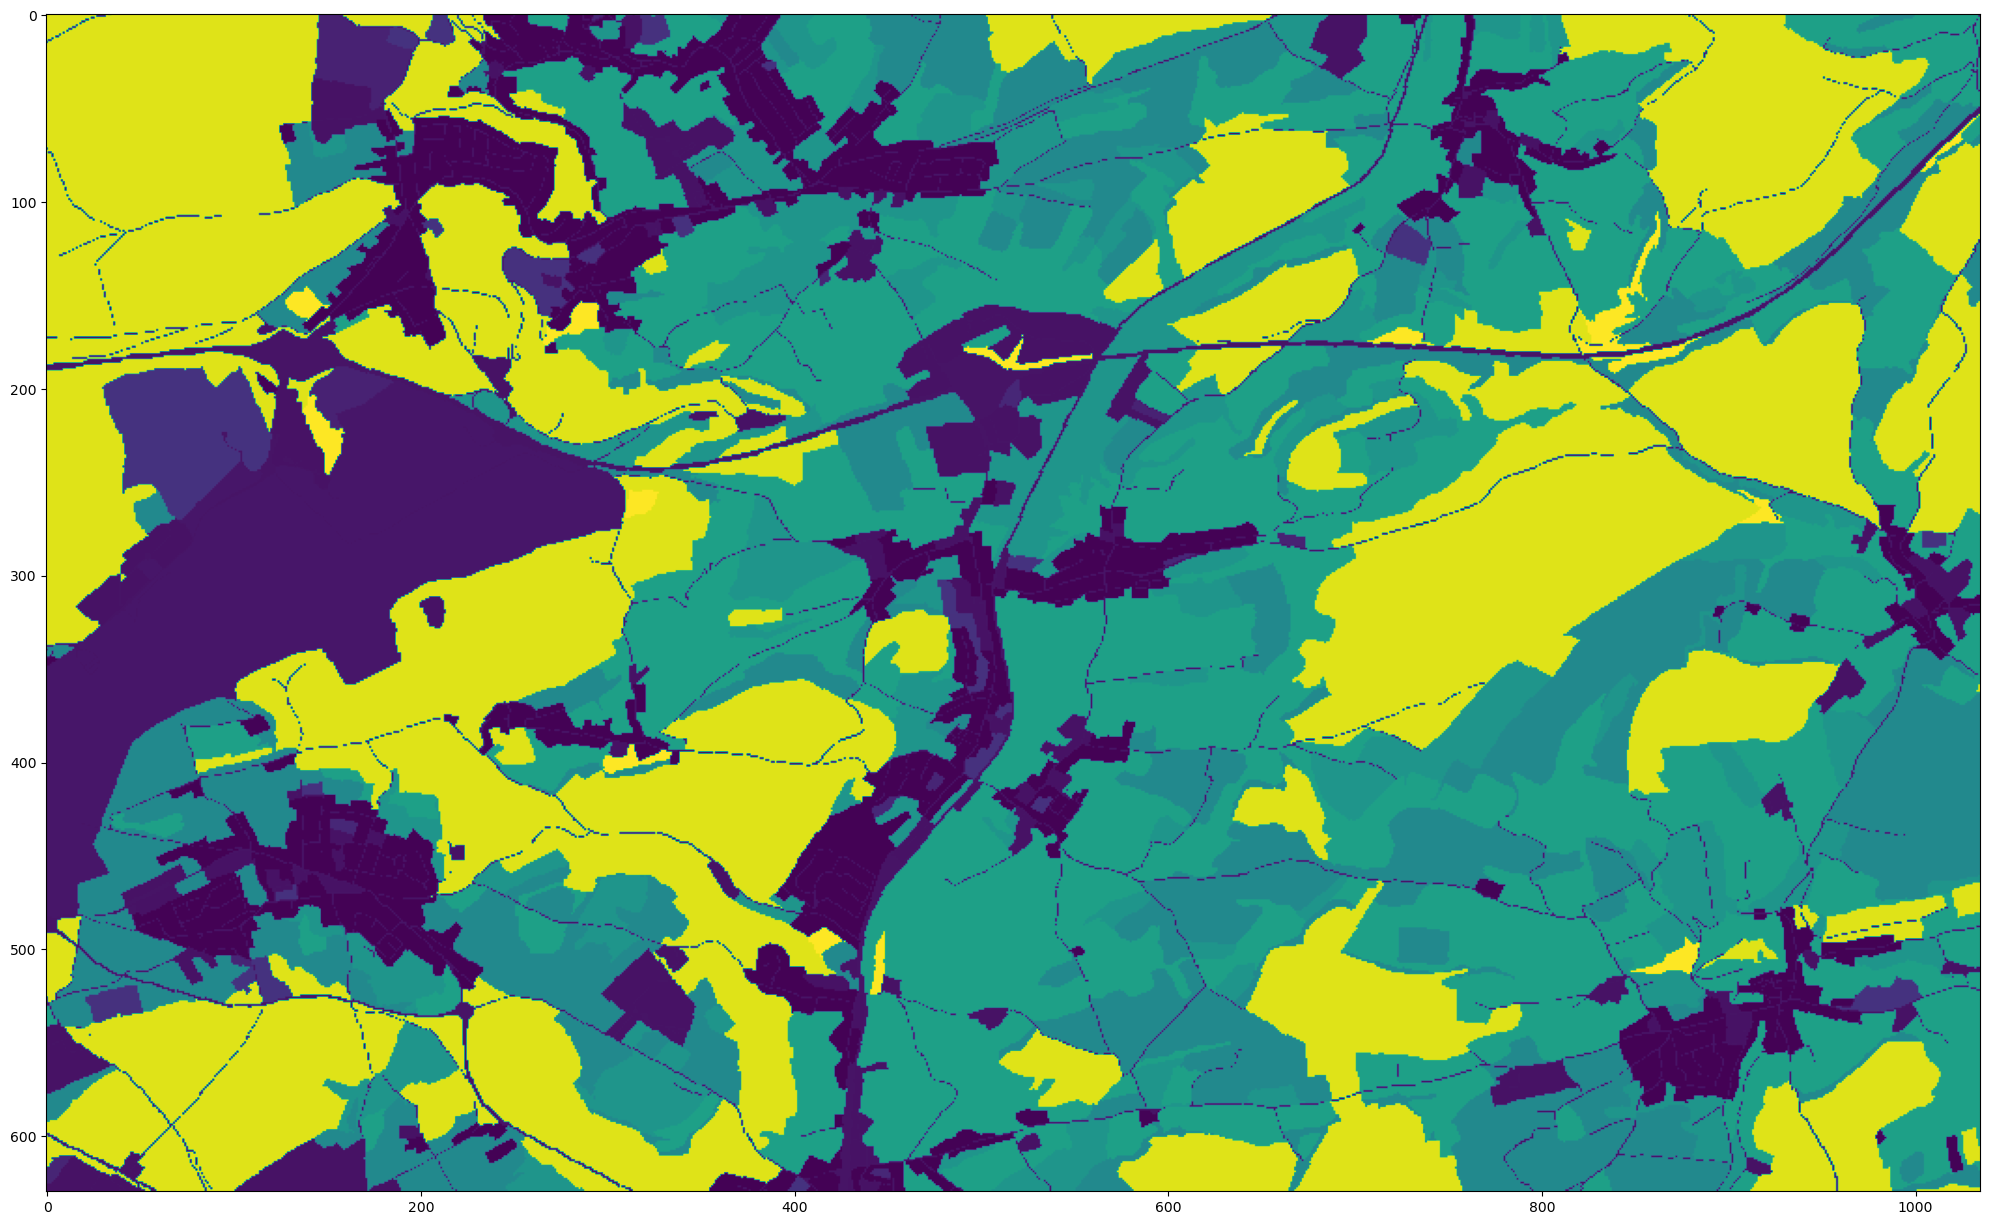

In [24]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.imshow(data)
# ax.set_title(tile_time.date().isoformat(), fontsize=10)

plt.tight_layout()

In [21]:
# show tile info in table format -- works for one tile
tile_iterator = byoc.iter_tiles(collection)
tiles_for_visualized = []
tiles_for_visualized.append(ByocTile.from_dict(next(tile_iterator)))

tiles_gdf = gpd.GeoDataFrame(
    tiles_for_visualized,
    geometry=[t.cover_geometry.transform(CRS.WGS84).geometry for t in tiles_for_visualized],
    crs="epsg:4326",
)
tiles_gdf

# show tile info in table format -- works for more than one tiles
# tile_iterator = byoc.iter_tiles(created_collection)
# tiles_for_visualized = []
# for i in range(100):
#     tiles_for_visualized.append(ByocTile.from_dict(next(tile_iterator)))

# tiles_gdf = gpd.GeoDataFrame(
#     tiles_for_visualized,
#     geometry=[t.cover_geometry.transform(CRS.WGS84).geometry for t in tiles_for_visualized],
#     crs="epsg:4326",
# )
# tiles_gdf.head()

,path,status,tile_id,tile_geometry,cover_geometry,created,sensing_time,additional_data,other_data,geometry
0,folder/(BAND).tif,INGESTED,4deec260-0fc0-401d-a763-300f08414e71,"Geometry(POLYGON ((4014670 3015540, 4071360 30...",Geometry(POLYGON ((4014669.999979591 2933829.9...,2023-02-17 10:46:31.166466+00:00,None,"{'hasAddedPoints': True, 'filesMetadata': {'Ur...",{'ingestionStart': '2023-02-17T10:46:31.166466Z'},"POLYGON ((5.77456 49.43812, 6.55538 49.46470, ..."


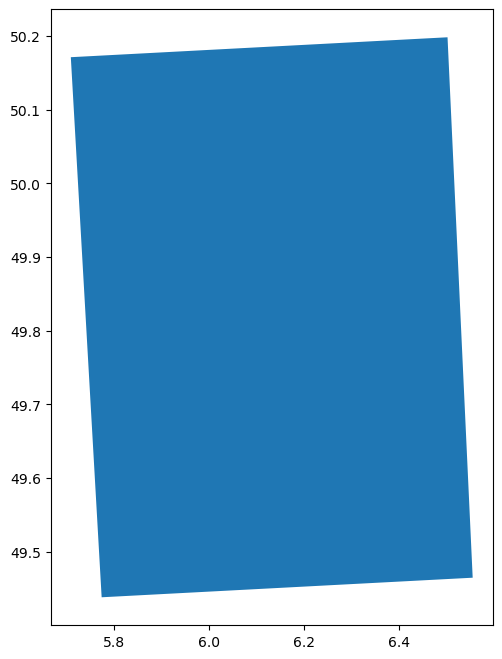

In [12]:
# show tile extent...
fig, ax = plt.subplots(figsize=(17, 8))
tiles_gdf.plot(ax=ax);